[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ourownstory/neural_prophet/blob/master/tutorials/feature-use/global_modeling.ipynb)

# Global Model
When fitting a single forecasting model with shared weights using a dataset composed of many time series, we can achieve what is known as a **global model**. It is specially useful in cases in which a single time series may not reflect the entire time series dynamics. In addition, global models provide better generalization and model size saving. In this notebook, we will build a global model using data from the hourly load of the ERCOT region.

First, we load the data:

In [4]:
if 'google.colab' in str(get_ipython()):
    !pip install git+https://github.com/ourownstory/neural_prophet.git # may take a while
    #!pip install neuralprophet # much faster, but may not have the latest upgrades/bugfixes

import pandas as pd
from neuralprophet import NeuralProphet, set_log_level
from neuralprophet import set_random_seed
set_random_seed(10)
set_log_level("ERROR", "INFO")

In [5]:
data_location = "https://raw.githubusercontent.com/ourownstory/neuralprophet-data/main/datasets/"
df_ercot = pd.read_csv(data_location + "multivariate/load_ercot_regions.csv")
df_ercot.head()

,ds,COAST,EAST,FAR_WEST,NORTH,NORTH_C,SOUTHERN,SOUTH_C,WEST,y
0,2004-01-01 01:00:00,7225.09,877.79,1044.89,745.79,7124.21,1660.45,3639.12,654.61,22971.94
1,2004-01-01 02:00:00,6994.25,850.75,1032.04,721.34,6854.58,1603.52,3495.16,639.88,22191.52
2,2004-01-01 03:00:00,6717.42,831.63,1021.10,699.70,6639.48,1527.99,3322.70,623.42,21383.44
3,2004-01-01 04:00:00,6554.27,823.56,1015.41,691.84,6492.39,1473.89,3201.72,613.49,20866.56
4,2004-01-01 05:00:00,6511.19,823.38,1009.74,686.76,6452.26,1462.76,3163.74,613.32,20723.15


We extract the name of the regions which will be later used in the model creation.

In [6]:
regions = list(df_ercot)[1:-1]

Global models can be enabled when the `df` input of the function is a dictionary composed of more than one pandas data frame in the expected format (column `ds`, which has the timestamps, and column `y`, which contains the observed values of the time series). We select data from a three years interval in our example (from 2004 to 2007).

In [7]:
df_list = list()
df_dict = {}
for cols in regions:
    aux = df_ercot[['ds', cols]].copy() #select column associated with region
    aux = aux.iloc[:26301, :].copy() #selects data up to 26301 row (2004 to 2007 time stamps)
    aux = aux.rename(columns = {cols: 'y'}) #rename column of data to 'y' which is compatible with Neural Prophet
    df_list.append(aux)
    df_dict[cols] = aux

When a dict is a input for the `split_df` function, train and validation data are provided in similar format type. The input data can be split according to a fraction of the time encopassing the whole dict (for a dict input and when `local_split=False`). If the user wants to split each of the time series exaclty as the `valid_p`, the `local_split` parameter must be set to True. This parameter is specially useful with dataframes with different time spans. In this example, we are going to split our data into train and test (with a 33% test proportion - 2 years train and 1 year test).

In [8]:
m = NeuralProphet(n_lags = 24)
df_train_dict, df_test_dict = m.split_df(df_dict, valid_p = 0.33, local_split = True)

Global modeling lets us train our model based on a global or a local normalization. In the latter, each time series is normalized locally (each time series has its respective data params). In the former, we have unique data params which will be used in all the time series at hand. 

## Global Modeling - Local Normalization

The default fitting of global models is based on local data normalization. Each time series will have data normalization parameters associated with each of the dictionary's keys provided. We are going to define a model which predicts the next hour based on the last 24 hours.

In [9]:
m = NeuralProphet(n_lags = 24)

After creating an object of the `NeuralProphet`, a model can be created by calling the `fit` function.

In [10]:
metrics = m.fit(df_train_dict, freq = 'H')

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

Ensure you provide data identified with the keys associated with the appropriate train time series. Therefore, suitable normalization data parameters are used in post-fitting procedures (i.e., `predict`, `test`).

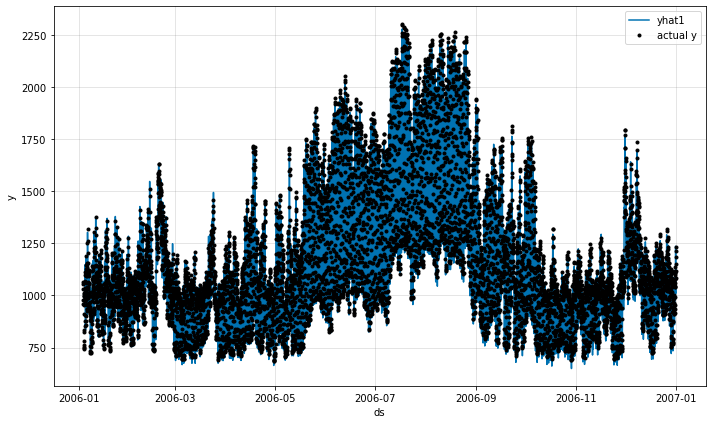

In [11]:
future = m.make_future_dataframe(df_test_dict, n_historic_predictions = True)
forecast = m.predict(future)
fig = m.plot(forecast['NORTH'])

Please note that in the case of local normalization, the test metrics are not re-scaled but displayed on a normalized scale.

In [12]:
test_metrics = m.test(df_test_dict)
test_metrics

,SmoothL1Loss,MAE,RMSE
0,0.000494,0.025199,0.030924


When using local normalization, the data parameters of the test time series may not be known. For example, let's say that hipothetically we just had the data from six of the regions provided. If we tested the model in a different region, we would not have suitable data params to normalize the data with.

In [13]:
regions.remove('NORTH')
df_train_dict_no_north = {k: df_train_dict[k].copy(deep=True) for k in regions}
df_test_north = df_test_dict['NORTH']

Although the 'NORTH' test data do not have any relation to the train series, local normalization can still be used to fit the model. However, the `unknown_data_normalization` input of the `NeuralProphet` object should be set to True. All post-fitting functions will normalize the test data according to global data parameters.

In [14]:
m = NeuralProphet(n_lags = 24, unknown_data_normalization = True)

In [15]:
metrics = m.fit(df_train_dict_no_north, freq = 'H')

  0%|          | 0/177 [00:00<?, ?it/s]

  0%|          | 0/177 [00:00<?, ?it/s]

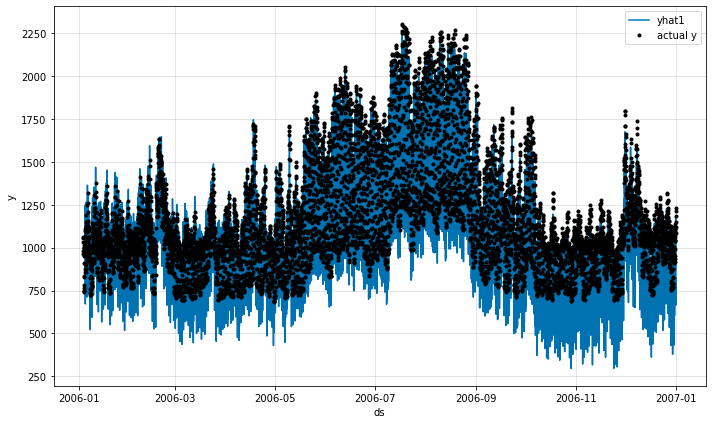

In [16]:

future = m.make_future_dataframe(df_test_north, n_historic_predictions = True)
forecast = m.predict(future)
fig = m.plot(forecast)

## Global Modeling - Global Normalization

In some cases, the global model may be fitted on data that is globally normalized. In this case, the user should set `global_normalization` to True when instantiating the `NeuralProphet` forecaster. When using global modeling global normalization, the keys of the provided dictionary either for train or test data are ignored. 


In [17]:
m = NeuralProphet(n_lags = 24, global_normalization = True)
metrics = m.fit(df_train_dict)

  0%|          | 0/178 [00:00<?, ?it/s]

  0%|          | 0/178 [00:00<?, ?it/s]

We can visualize the parameters of the trained models.

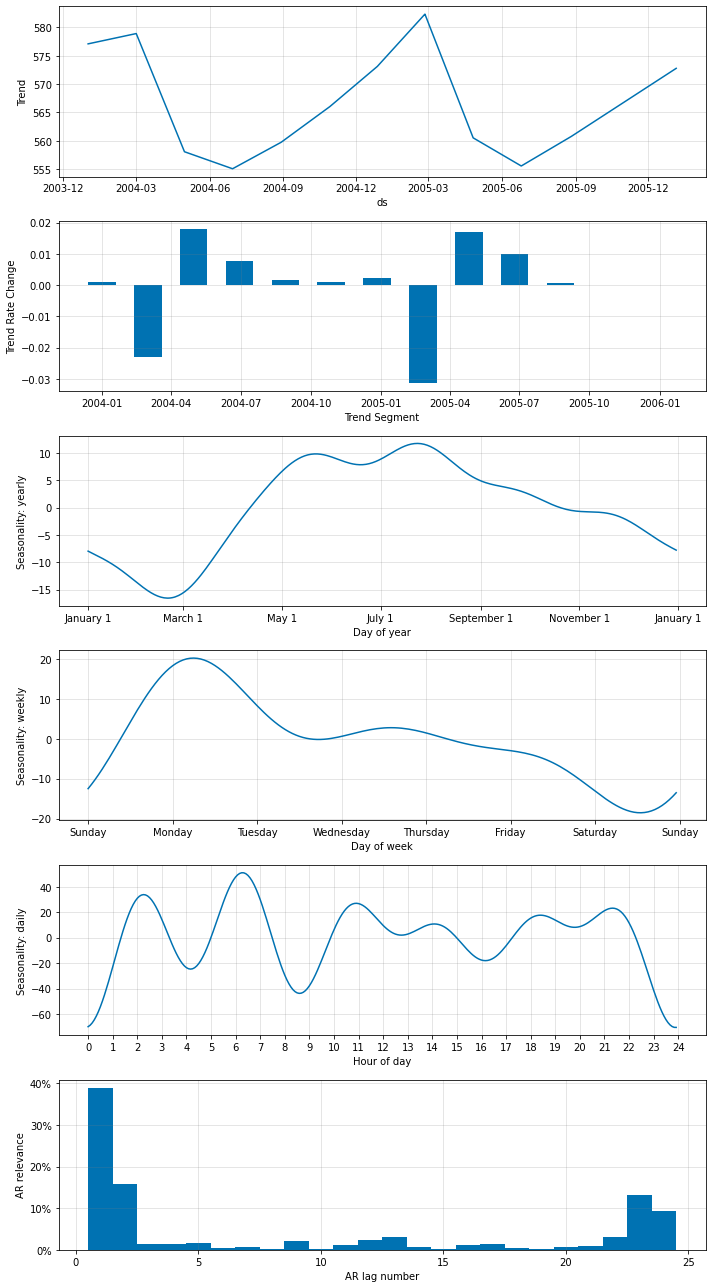

In [18]:
fig_param = m.plot_parameters()

We can evaluate the test metrics considering the dict of dataframes from all regions.

In [19]:
test_metrics = m.test(df_test_north)
test_metrics

,SmoothL1Loss,MAE,RMSE
0,0.000006,33.806532,40.299941


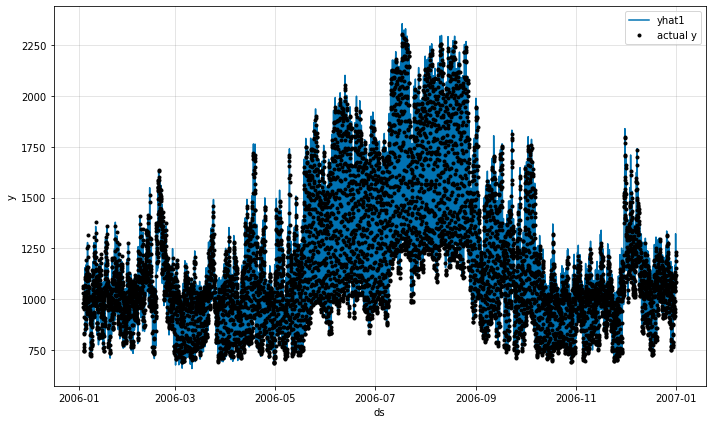

In [20]:
future = m.make_future_dataframe(df_test_dict, n_historic_predictions = True)
forecast = m.predict(future)
fig = m.plot(forecast['NORTH'])